In [2]:
import nextnanopy as nn
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# base_file_path = r"C:\Users\splatt\Documents\nextnano\Output\InGaAsInAlAs_6nm_valence_band_anticrossing_check_sweep_template\InGaAsInAlAs_6nm_valence_band_anticrossing_check_sweep_template.nnp"
base_filename = 'InGaAsInAlAs_thinner_valencesubbands_quantumonly_check_maxVB'
parent_dir = r'C:\Users\splatt\Documents\nextnano\Output\InGaAsInAlAs_thinner_valencesubbands_quantumonly_check_maxVB(1)'

input_filepath = os.path.join(parent_dir, base_filename + '.nnp')
# base_file_input = nn.InputFile(input_filepath,product='nextnano++')

# print(base_file_input)

In [5]:
class SimOut:
    def __init__(self, sweepvar):
        self.sweep_var_value = sweepvar
        self.Gamma = None
        self.HH = None
        self.LH = None
        self.CB_subband_probs = None
        self.VB_subband_probs = None
        self.E_CB = None
        self.E_VB = None

In [16]:
def build_output(outpath,quantum_region,quantum_band,quantum_band_interactions,bias,VB_cutoff,well_w):
    sweep_bar = SimOut(sweepvar=well_w)

    band_edge = nn.DataFile(os.path.join(outpath, bias, 'bandedges.dat'),'nextnano++')
    sweep_bar.Gamma = band_edge.variables['Gamma']
    sweep_bar.HH = band_edge.variables['HH']
    sweep_bar.LH = band_edge.variables['LH']

    quantum_sims_path = os.path.join(outpath, bias, quantum_region)
    energy_spectrum = nn.DataFile(os.path.join(quantum_sims_path, quantum_band,'energy_spectrum_k00000.dat'),'nextnano++')
    probabilities = nn.DataFile(os.path.join(quantum_sims_path, quantum_band,'probabilities_shift_k00000.dat'),'nextnano++')
    tansition_energies = nn.DataFile(os.path.join(quantum_sims_path, quantum_band_interactions, 'transition_energies_k00000.txt'),'nextnano++')

    #further processing
    non_degen_probabilities_CB = []
    non_degen_probabilities_VB = []
    non_degen_E = []
    non_degen_E_CB = []
    non_degen_E_VB = []

    non_degen_E_CB_inds = []
    non_degen_E_VB_inds = []

    for psi in probabilities.variables:
        parts = psi.name.split('_')
        if len(parts) > 1 and parts[-1].isdigit():
            num = int(parts[-1])
            if num % 2 == 1:  # odd numbe
                if 'E' in psi.name:
                    non_degen_E.append(np.mean(psi.value))
                    if np.mean(psi.value) < VB_cutoff:
                        non_degen_E_VB.append(np.mean(psi.value))  # Plot only for E < 0.5 eV
                        non_degen_E_VB_inds.append(num)
                    else:
                        non_degen_E_CB.append(np.mean(psi.value))
                        non_degen_E_CB_inds.append(num)


    for psi in probabilities.variables:
        if 'Psi^2' in psi.name:
            psiind = int(psi.name.split('_')[-1])
            if psiind in non_degen_E_CB_inds:
                non_degen_probabilities_CB.append(psi.value)
            if psiind in non_degen_E_VB_inds:
                non_degen_probabilities_VB.append(psi.value)

    sweep_bar.CB_subband_probs = non_degen_probabilities_CB
    sweep_bar.VB_subband_probs = non_degen_probabilities_VB
    sweep_bar.E_CB = non_degen_E_CB
    sweep_bar.E_VB = non_degen_E_VB

    return sweep_bar

In [17]:
VB_cutoff = 2
bias = r'bias_00000'
quantum_region = r'Quantum\quantum_region'
quantum_band = r'kp8'
quantum_band_interactions = r'kp8_kp8'
simout = build_output(parent_dir,quantum_region,quantum_band,quantum_band_interactions,bias,VB_cutoff,6.0)

In [39]:
simout.Gamma
simout.CB_subband_probs
simout.E_CB
simout.E_VB
print(simout.E_VB)
print(simout.E_CB)


[np.float64(1.4042682497901997), np.float64(1.4168723848632003), np.float64(1.4416009892782997), np.float64(1.5173950602122), np.float64(1.5230840245570003), np.float64(1.5683104897863003)]
[np.float64(2.4916313352762), np.float64(2.7197716136148995)]


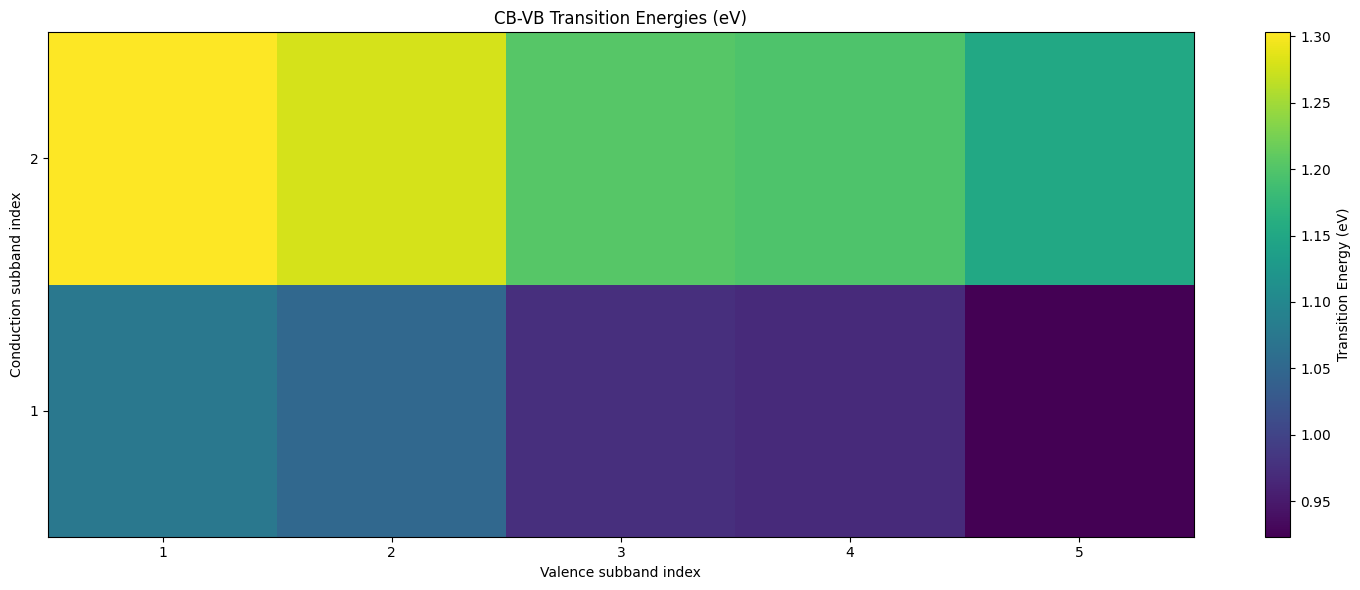


Transition Energies Table:
 VB Energy (eV) (subband num) | CB Energy (eV) (subband num) | Transition Energy (eV)
-------------------------------------------------------
         1.42 (1) |         2.49 (1) |                1.07
         1.44 (2) |         2.49 (1) |                1.05
         1.52 (3) |         2.49 (1) |                0.97
         1.52 (4) |         2.49 (1) |                0.97
         1.57 (5) |         2.49 (1) |                0.92
         1.42 (1) |         2.72 (2) |                1.30
         1.44 (2) |         2.72 (2) |                1.28
         1.52 (3) |         2.72 (2) |                1.20
         1.52 (4) |         2.72 (2) |                1.20
         1.57 (5) |         2.72 (2) |                1.15


In [56]:
# Create transition energy heatmap
import numpy as np
# import seaborn as sns

# Create meshgrid of all VB to CB transitions
# E_VB = np.array(simout.E_VB)
# E_CB = np.array(simout.E_CB)
real_VB = simout.E_VB[1:]
# Create meshgrid for all combinations
VB_mesh, CB_mesh = np.meshgrid(real_VB, simout.E_CB)
transition_energies = CB_mesh - VB_mesh # Transpose VB mesh to get correct orientation

# Create figure with two subplots side by side
fig, ax1= plt.subplots(figsize=(15, 6))

# Plot 1: pcolormesh for precise control
# pcm = ax1.pcolormesh(simout.E_VB, simout.E_CB, transition_energies, shading='nearest', cmap='viridis')
pcm = ax1.pcolormesh(np.arange(len(real_VB))+1, np.arange(len(simout.E_CB))+1, transition_energies, shading='nearest', cmap='viridis')
# matshowtest = ax1.matshow(transition_energies)
ax1.set_xlabel('Valence subband index')
ax1.set_ylabel('Conduction subband index')
ax1.set_title('CB-VB Transition Energies (eV)')


ax1.set_xticks(np.arange(1, len(real_VB)+1))
ax1.set_yticks(np.arange(1, len(simout.E_CB)+1))

fig.colorbar(pcm, ax=ax1, label='Transition Energy (eV)')

plt.tight_layout()
plt.show()

# Print transition table
print("\nTransition Energies Table:")
print(" VB Energy (eV) (subband num) | CB Energy (eV) (subband num) | Transition Energy (eV)")
print("-" * 55)
for i, cb in enumerate(simout.E_CB):
    for j, vb in enumerate(real_VB):
        print(f" {vb:12.2f} ({j+1}) | {cb:12.2f} ({i+1}) | {transition_energies[i,j]:19.2f}")